## Evaluación del modelo

In [39]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve,
    accuracy_score, 
    precision_score, 
    recall_score
)
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
import seaborn as sns
from tabulate import tabulate
import numpy as np
import sys

In [40]:
sys.path.append("../..")

In [41]:
%load_ext autoreload
%autoreload 2

from src.utils.utils import (
    json_dump_dict,
    load_df
)
from src.utils.params import (
#     param_grid,
#     max_features,
#     n_estimators,
    evaluation_metric,
    feature_importance_theshold,
    tag_non_relevant_cats,
    ingestion_pickle_loc,
    transformation_pickle_loc,
    models_pickle_loc,
    X_train_pickle_loc,
    y_train_pickle_loc,
    X_test_pickle_loc,
    y_test_pickle_loc,
    test_predict_labs_pickle_loc,
    test_predict_scores_pickle_loc,
    aequitas_df_pickle_loc
)
from src.pipelines.model_evaluation import (
    get_metrics_report,
    curva_roc,
    tabla_referencia,
    tabla_confusion,
    precision_at_k,
    recall_at_k,
    curva_pre_re,
    f_predicted_labels
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- La tabla de métricas de tu mejor modelo
- La curva ROC
- La curva de precision y recall
- Las tablas de métricas obtenidas de la clase Group de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Group
- Las tablas de métricas obtenidas de la clase Bias de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Bias (disparidad)
- Las tablas de métricas obtenidas de la clase Fairness de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Fairness (equidad)

In [4]:
y_test = load_df("../../" +y_test_pickle_loc)

In [5]:
# predicciones con el mejor predictor 
predicted_scores = load_df("../../" +test_predict_scores_pickle_loc)

In [7]:
predicted_labels=f_predicted_labels(y_test,predicted_scores,0.18)

In [8]:
predicted_labels.shape

(414942,)

In [9]:
predicted_scores.shape

(414942, 2)

In [10]:
y_test.shape

(414942,)

## Métricas de desempeño

### ROC y AUC

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

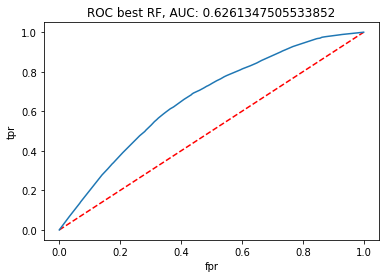

In [12]:
curva_roc(y_test,predicted_labels,fpr,tpr)

Para las curvas ROC se asume que si la línea azul se acerca a la línea roja, nuestro modelo está casi adivinando nuestras falsas alarmas. Además, la métrica de Área bajo la Curva, arroja un valor que se considera muy regular.

### Matriz de confusión

In [13]:
print(tabla_referencia())

Dato\Predicción    Etiqueta +           Etiqueta -
-----------------  -------------------  -------------------
Etiqueta +         True Positive (tp)   False Negative (fn)
Etiqueta -         False Positive (fp)  True Negative (tn)


In [14]:
print(tabla_confusion(confusion_matrix(y_test, predicted_labels, normalize='all')))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +            0.445988       0.349815
Etiqueta -            0.0629245      0.141273


In [15]:
print(tabla_confusion(confusion_matrix(y_test, predicted_labels)))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               185059        145153
Etiqueta -                26110         58620


Nuestras matrices de confusión muestran que tenemos una proporción de 0.44 de observaciones que se predicen adecuadamente, mientras que la siguiente proporción más alta (0.34) es cuando el dato real era falsa alarma y nuestro modelo predijo que no era falsa alarma. La siguiente proporción es cuando se predecían correctamente las etiquetas negativas. Esto nos da un indicio del comportamiento de nuestro modelo, sin embargo, lo analizaremos a detalle a continuación.

### Accuracy

$$accuracy=\frac{\text{tp+tn}}{\text{tp+fp+tn+fn}}= \frac{\text{predichos correctamente}}{\text{total}}$$

In [16]:
accuracy_score(y_test, predicted_labels)

0.5872603881988326

De la accuracy, se observa un valor cercano al azar que se consideraría regular.

### Precision


$$precision=\frac{\text{tp}}{\text{tp+fp}}= \frac{\text{predichos positivos correctos}}{\text{predichos positivos}}$$

De los que identificamos como clase positiva, cuántos identificamos correctamente -pureza en nuestra predicción-. 

### Recall

$$recall=\frac{\text{tp}}{\text{tp+fn}}= \frac{\text{predichos positivos correctos}}{\text{datos positivos}}$$

Del universo posible de nuestra clase positiva, cúantos identificamos correctamente.

#### F1-score

Combina precision y recall para obtimizar ambos.

$$F=2\cdot  \left( \frac{\text{precision}\cdot \text{recall}}{\text{precision + recall}} \right)$$

In [17]:
#### Precision, recall, thresholds
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [18]:
thresholds_2 = np.append(thresholds_2, 1)

In [19]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.061789,0.204230,1.000000,0.339187,1.000000,0.999800,0.000200,0.000000
1,0.062372,0.204316,0.999953,0.339303,0.999953,0.999225,0.000775,0.000047
2,0.062452,0.204323,0.999941,0.339313,0.999941,0.999167,0.000833,0.000059
3,0.062490,0.204425,0.999823,0.339447,0.999823,0.998422,0.001578,0.000177
4,0.062552,0.204458,0.999799,0.339490,0.999799,0.998198,0.001802,0.000201
...,...,...,...,...,...,...,...,...
935,0.303305,0.341528,0.142323,0.200918,0.142323,0.070409,0.929591,0.857677
936,0.305946,0.340072,0.135607,0.193896,0.135607,0.067523,0.932477,0.864393
937,0.306196,0.339078,0.128172,0.186026,0.128172,0.064104,0.935896,0.871828
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329


En nuestra tabla de métricas observamos que para diferentes umbrales las métricas de precision, recall, f1_score, los tpr, los fpr, los tnr y los fnr. El objetivo del proyecto que es detectar las falsas alarmas cuando realmente lo son. Sin embargo, consideramos importante detectar con mayor precisión los falsos positivos pues es el escenario donde estamos detectando una falsa alarma cuando realmente no lo es y la emergencia es verdadera, por lo que se pone en juego la vida de personas. Debido a esto y observando las métricas se sugiere una tasa de 0.06 para el negocio. 

In [20]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329
939,0.309855,0.345156,0.059377,0.101323,0.059377,0.028906,0.971094,0.940623


Con esto modelos ahora seleccionamos un nuevo punto de corte y generamos nuevos labels para ver el comportamiento de este modelo.

In [21]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.308562718472398

In [22]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [23]:
pd.Series(new_labels).sum()

16360

De acuerdo a las nuevas etiquetas observamos la nueva matriz de confusión y la comparamos con la anterior.

In [24]:
print(tabla_confusion(confusion_matrix(y_test, new_labels, normalize='all')))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +             0.76999      0.0258132
Etiqueta -             0.190583     0.013614


In [25]:
print(tabla_confusion(confusion_matrix(y_test, predicted_labels, normalize='all')))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +            0.445988       0.349815
Etiqueta -            0.0629245      0.141273


Con el nuevo punto de corte se observa que tenemos mayor proporción de etiquetas predichas correctamente, y que decrementa la proporción de falsos negativos que era el objetivo del C5. Sin embargo, los falsos positivos aumentan por lo que dejaríamos a consideración probar otros modelos para obtener mejorar la predicción de nuestro modelo. 

Por último revisaremos las métricas de precision@k y recall@k, que recordemos estábamos más enfocados a la precisión pues las consecuencias de nuestra predicción pueden ser punitivas en el caso de los falsos positivos. Para elegir el k, sabemos que contamos con 20 ambulancias y sabemos que el promedio de accidentes por día es de alrededor de 550, por lo que obtuvimos un k de:

In [61]:
k=20/551
k

0.036297640653357534

Para las cuales se obtienen las métricas de precision@k y recall@k:

In [62]:
precision_at_k(y_test,predicted_scores[:,1],k)

0.34529339853300733

In [65]:
recall_at_k(y_test,predicted_scores[:,1],k)

0.0666706007317361

Y obtenemos la curva de presicion y recall:

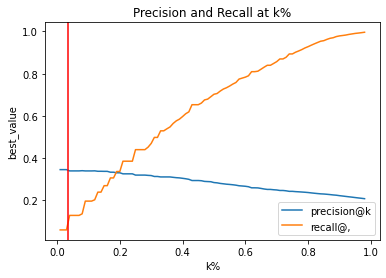

In [64]:
curva_pre_re(y_test, predicted_scores[:,1],k)

Esta se observa que para un valor de k de 0.036, tenemos un recall de alrededor 0.06 y una precision de alrededor 0.34. Si tuvieramos la cobertura máxima, es decir, que tuvieramos más ambulancias para los accidentes, nuestro modelo podría tener mayor cobertura y su eficiencia sería mucho menor. Esto podría indicar que no es un buen modelo para nuestro problema pues esperaríamos que con pocos recursos nuestra eficiencia fuera mucho mayor, sin embargo, no lo es. Por otro lado su cobertura si mejora conforme se tienen más recursos pero esta no era la métrica que consideramos tenía mayor peso. Debido a esto sugerimos evaluar otro modelo. 

## Aequitas

Se eligieron los 

In [42]:
df_aeq = load_df("../../" + aequitas_df_pickle_loc)

In [43]:
def prep_data(dfx):
    #Load original dataframe with features
    df_o = pd.read_csv('/Volumes/MemoriaEle/HeavyData/incidentes-viales-c5.csv')
    #df_o = pd.read_csv("../../" + "data/incidentes-viales-c5.csv")
    df_o.drop(df_o[df_o.delegacion_inicio.isnull()].index, inplace = True)
    df_aeq=pd.merge(dfx, df_o, on='folio', how='left')
    df_aeq=df_aeq.loc[:, ['folio','label','score','delegacion_inicio']]
    
    return df_aeq   

In [44]:
df_aeq = prep_data(df_aeq)

In [45]:
df_aeq = df_aeq.rename(columns = {'folio':'entity_id','label': 'label_value'}, inplace = False)

In [46]:
df_aeq.head()

,entity_id,label_value,score,delegacion_inicio
0,C5/190613/06795,0.0,0,COYOACAN
1,C4/150322/02894,0.0,0,GUSTAVO A. MADERO
2,C5/180302/01135,0.0,0,IZTAPALAPA
3,C5/190411/07684,0.0,0,TLAHUAC
4,C5/170212/06529,0.0,1,COYOACAN


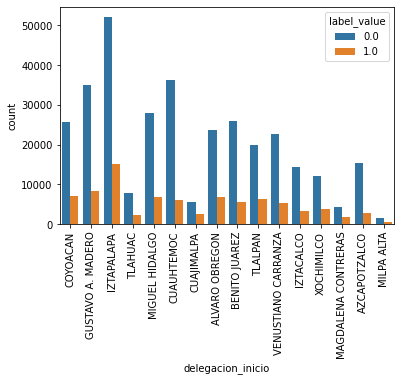

In [47]:
by_del = sns.countplot(x="delegacion_inicio", hue="label_value", 
                        data=df_aeq[df_aeq.delegacion_inicio.isin(['COYOACAN', 'GUSTAVO A. MADERO', 'IZTAPALAPA', 'TLAHUAC',
       'MIGUEL HIDALGO', 'CUAUHTEMOC', 'CUAJIMALPA', 'ALVARO OBREGON',
       'BENITO JUAREZ', 'TLALPAN', 'VENUSTIANO CARRANZA', 'IZTACALCO',
       'XOCHIMILCO', 'MAGDALENA CONTRERAS', 'AZCAPOTZALCO', 'MILPA ALTA'])])
l=plt.setp(by_del.get_xticklabels(), rotation=90)

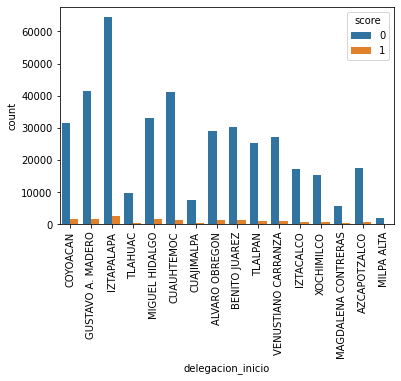

In [48]:
by_del = sns.countplot(x="delegacion_inicio", hue="score", 
                        data=df_aeq[df_aeq.delegacion_inicio.isin(['COYOACAN', 'GUSTAVO A. MADERO', 'IZTAPALAPA', 'TLAHUAC',
       'MIGUEL HIDALGO', 'CUAUHTEMOC', 'CUAJIMALPA', 'ALVARO OBREGON',
       'BENITO JUAREZ', 'TLALPAN', 'VENUSTIANO CARRANZA', 'IZTACALCO',
       'XOCHIMILCO', 'MAGDALENA CONTRERAS', 'AZCAPOTZALCO', 'MILPA ALTA'])])
l=plt.setp(by_del.get_xticklabels(), rotation=90)

In [49]:
def group(df):
    """
     args:
         df (dataframe):Recibe el data frame que tiene los features sobre los que queremos medir el sesgo entre los diferentes grupos.

     returns:
         -
     """
    #tables
    g = Group()
    xtab, attrbs = g.get_crosstabs(df)
    absolute_metrics = g.list_absolute_metrics(xtab)
    conteos_grupo=xtab[[col for col in xtab.columns if col not in absolute_metrics]]
    metricas_absolutas=xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

    return xtab, conteos_grupo,metricas_absolutas

In [50]:
xtab, conteos_grupo,metricas_absolutas=group(df_aeq)

model_id, score_thresholds 0 {'rank_abs': [16360]}


In [51]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,16360,delegacion_inicio,ALVARO OBREGON,0.063986,0.962559,0.218950,0.669947,0.037441,...,0.043381,885,6378,22752,436,6814,23637,30451,414942,0.223769
1,0,binary 0/1,16360,delegacion_inicio,AZCAPOTZALCO,0.049607,0.968083,0.157751,0.771293,0.031917,...,0.034751,489,2778,14832,145,2923,15321,18244,414942,0.160217
2,0,binary 0/1,16360,delegacion_inicio,BENITO JUAREZ,0.078726,0.967264,0.166915,0.664062,0.032736,...,0.040729,850,5032,25115,430,5462,25965,31427,414942,0.173800
3,0,binary 0/1,16360,delegacion_inicio,COYOACAN,0.077451,0.964191,0.210051,0.624576,0.035809,...,0.044865,920,6587,24772,553,7140,25692,32832,414942,0.217471
4,0,binary 0/1,16360,delegacion_inicio,CUAJIMALPA,0.050658,0.962416,0.310908,0.618619,0.037584,...,0.041688,206,2380,5275,127,2507,5481,7988,414942,0.313846
5,0,binary 0/1,16360,delegacion_inicio,CUAUHTEMOC,0.061043,0.973584,0.140821,0.718025,0.026416,...,0.031446,960,5799,35381,377,6176,36341,42517,414942,0.145260
6,0,binary 0/1,16360,delegacion_inicio,GUSTAVO A. MADERO,0.065378,0.965400,0.188594,0.687927,0.034600,...,0.040559,1208,7834,33705,548,8382,34913,43295,414942,0.193602
7,0,binary 0/1,16360,delegacion_inicio,IZTACALCO,0.054062,0.968186,0.182826,0.719875,0.031814,...,0.035959,460,3132,13999,179,3311,14459,17770,414942,0.186325
8,0,binary 0/1,16360,delegacion_inicio,IZTAPALAPA,0.066755,0.968024,0.217540,0.624204,0.031976,...,0.039761,1666,14022,50435,1003,15025,52101,67126,414942,0.223833
9,0,binary 0/1,16360,delegacion_inicio,MAGDALENA CONTRERAS,0.059133,0.971963,0.278654,0.542986,0.028037,...,0.036907,120,1607,4160,101,1708,4280,5988,414942,0.285237


In [52]:
conteos_grupo

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,16360,delegacion_inicio,ALVARO OBREGON,1321,29130,885,6378,22752,436,6814,23637,30451,414942
1,0,binary 0/1,16360,delegacion_inicio,AZCAPOTZALCO,634,17610,489,2778,14832,145,2923,15321,18244,414942
2,0,binary 0/1,16360,delegacion_inicio,BENITO JUAREZ,1280,30147,850,5032,25115,430,5462,25965,31427,414942
3,0,binary 0/1,16360,delegacion_inicio,COYOACAN,1473,31359,920,6587,24772,553,7140,25692,32832,414942
4,0,binary 0/1,16360,delegacion_inicio,CUAJIMALPA,333,7655,206,2380,5275,127,2507,5481,7988,414942
5,0,binary 0/1,16360,delegacion_inicio,CUAUHTEMOC,1337,41180,960,5799,35381,377,6176,36341,42517,414942
6,0,binary 0/1,16360,delegacion_inicio,GUSTAVO A. MADERO,1756,41539,1208,7834,33705,548,8382,34913,43295,414942
7,0,binary 0/1,16360,delegacion_inicio,IZTACALCO,639,17131,460,3132,13999,179,3311,14459,17770,414942
8,0,binary 0/1,16360,delegacion_inicio,IZTAPALAPA,2669,64457,1666,14022,50435,1003,15025,52101,67126,414942
9,0,binary 0/1,16360,delegacion_inicio,MAGDALENA CONTRERAS,221,5767,120,1607,4160,101,1708,4280,5988,414942


In [53]:
metricas_absolutas

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion_inicio,ALVARO OBREGON,0.06,0.96,0.22,0.67,0.04,0.94,0.78,0.33,0.08,0.04,0.22
1,delegacion_inicio,AZCAPOTZALCO,0.05,0.97,0.16,0.77,0.03,0.95,0.84,0.23,0.04,0.03,0.16
2,delegacion_inicio,BENITO JUAREZ,0.08,0.97,0.17,0.66,0.03,0.92,0.83,0.34,0.08,0.04,0.17
3,delegacion_inicio,COYOACAN,0.08,0.96,0.21,0.62,0.04,0.92,0.79,0.38,0.09,0.04,0.22
4,delegacion_inicio,CUAJIMALPA,0.05,0.96,0.31,0.62,0.04,0.95,0.69,0.38,0.02,0.04,0.31
5,delegacion_inicio,CUAUHTEMOC,0.06,0.97,0.14,0.72,0.03,0.94,0.86,0.28,0.08,0.03,0.15
6,delegacion_inicio,GUSTAVO A. MADERO,0.07,0.97,0.19,0.69,0.03,0.93,0.81,0.31,0.11,0.04,0.19
7,delegacion_inicio,IZTACALCO,0.05,0.97,0.18,0.72,0.03,0.95,0.82,0.28,0.04,0.04,0.19
8,delegacion_inicio,IZTAPALAPA,0.07,0.97,0.22,0.62,0.03,0.93,0.78,0.38,0.16,0.04,0.22
9,delegacion_inicio,MAGDALENA CONTRERAS,0.06,0.97,0.28,0.54,0.03,0.94,0.72,0.46,0.01,0.04,0.29


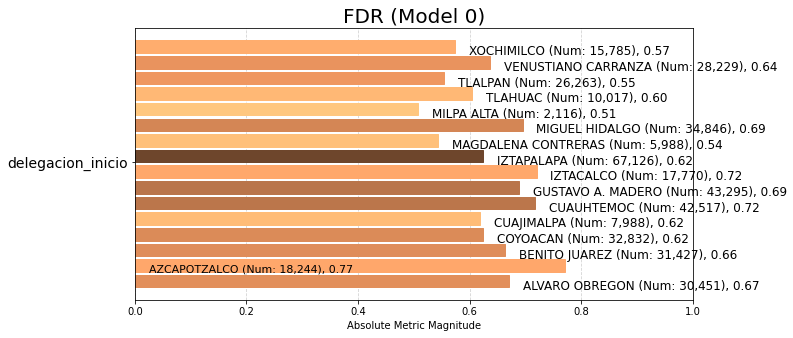

In [59]:
aeq = Plot()
fdr = aeq.plot_group_metric(xtab, 'fdr')

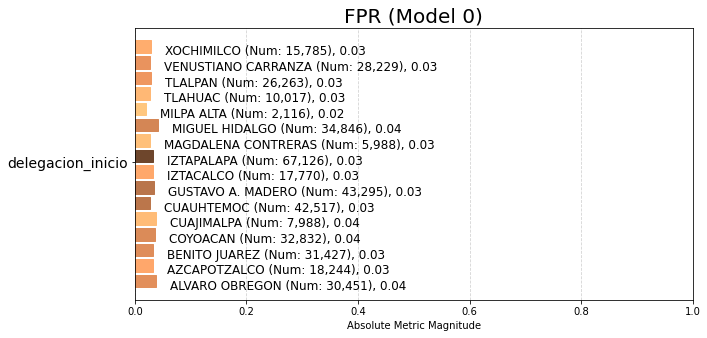

In [61]:
fdr = aeq.plot_group_metric(xtab, 'fpr')

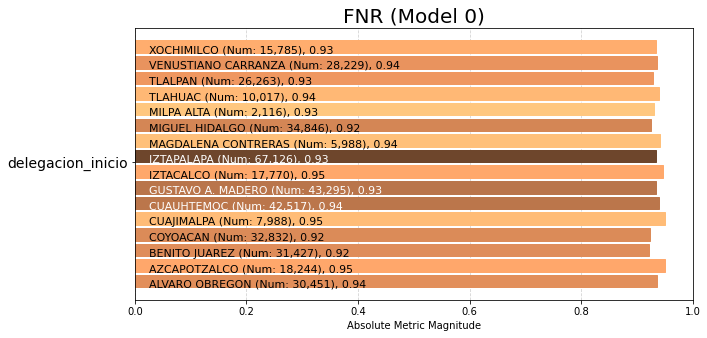

In [62]:
fdr = aeq.plot_group_metric(xtab, 'fnr')

In [63]:
bias = Bias()

In [64]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=df_aeq, 
                                        ref_groups_dict={'delegacion_inicio':'IZTAPALAPA'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)

get_disparity_predefined_group()


In [37]:
#def bias(df_aeq): 
#    """
#     args:
#        df (dataframe): Recibe el data frame que tiene los features sobre los que queremos medir la disparidad
#     returns:
#        -
#   """
bias = Bias()
bdf = bias.get_disparity_predefined_groups(xtab, 
                                           original_df=df_aeq, 
                                    ref_groups_dict={'delegacion_inicio':'IZTAPALAPA'}, 
                                    alpha=0.05, check_significance=True, 
                                    mask_significance=True)
bdf[['attribute_name', 'attribute_value'] + bias.list_disparities(bdf)].round(2)

#return bdf, m_disparity

get_disparity_predefined_group()


KeyError: 'binary_score'

In [36]:
bdf, m_disparity=bias(df_aeq)

get_disparity_predefined_group()


KeyError: 'binary_score'

In [ ]:
aeq = Plot()
m_disparity = aeq.plot_disparity_all(majority_bdf,  
                                     metrics=['fpr','fdr','fnr'], 
                                     significance_alpha=0.05)